<h1 style="color: green">Beijing Air Quality Data (2010-15)</h1>
<h1 style="font-size:32px;">TIME SERIES MODEL</h1>

<hr>

## Table of Contents
* [1. Data Transformation](#dtransf)
    * [1.1 Convert to Time Series](#dtransf_ts)
    * [1.2 Seasonal Variation / Trend Decomposition](#dtransf_st)
    * [1.3 Discard Not Needed / Convert Categorical](#dtransf_etc)
    * [1.4 Normalize High Variance Variables](#dtransf_norm)
* [2. SARIMAX Model](#sarimax)
    * [2.1 First-Pass Model](#sarimax_1)
    * [2.2 Final Model](#sarimax_2)
* [3. Results](#results)
        
<hr>

#### Load Modeled Data & Modules

In [980]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import RobustScaler, quantile_transform
from sklearn.model_selection import KFold

from statsmodels.tsa.api import VAR, DynamicVAR

In [981]:
beijing = pd.read_csv("beijing.csv")
beijing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
No             43824 non-null int64
year           43824 non-null int64
month          43824 non-null int64
day            43824 non-null int64
hour           43824 non-null int64
pm2.5          41757 non-null float64
DEWP           43824 non-null int64
TEMP           43824 non-null float64
PRES           43824 non-null float64
cbwd           43824 non-null object
Iws            43824 non-null float64
Is             43824 non-null int64
Ir             43824 non-null int64
model_pm2.5    43824 non-null float64
dtypes: float64(5), int64(8), object(1)
memory usage: 4.7+ MB


# 1. Data Transformations <a class="anchor" id="dtransf"></a>
## 1.1 Convert to Time Series <a class="anchor" id="dtransf_ts"></a>

In [982]:
# Convert to Datetime
def dmy2datetime(x):
    s = "{day:02d}-{month:02d}-{year:04d} {hour:02d}".format(**x)
    return pd.to_datetime(s,format="%d-%m-%Y %H")
beijing.index = pd.Index(beijing.apply(dmy2datetime , axis=1),name="day_hour")

## 1.2 Seasonal Variation / Trend Decomposition <a class="anchor" id="dtransf_st"></a>
Not Performed

- In principle there is yearly cycle, but only 5 cycles are observed.

No Clear Seasonal Effect


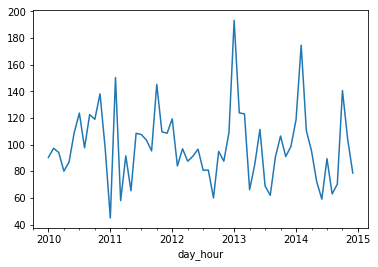

In [983]:
print("No Clear Seasonal Effect")
ax = beijing['pm2.5'].resample('M').mean().plot()

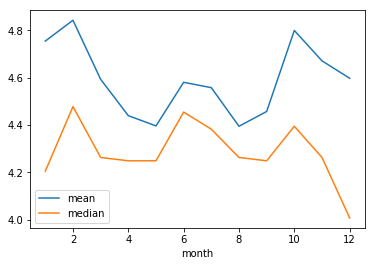

In [984]:
ax = beijing.groupby('month')['pm2.5'].agg(['mean','median']).apply(lambda x: np.log1p(x),axis=1).plot()

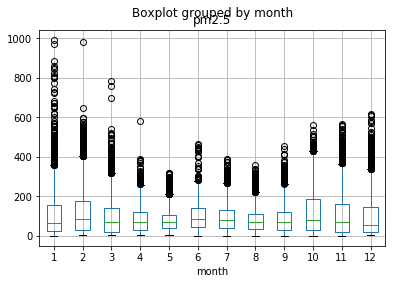

In [985]:
ax = beijing.boxplot('pm2.5',by='month')

## 1.3 Discard Not Needed /  Convert Categorical<a class="anchor" id="dtransf_etc"></a>

In [986]:
# Drop Unwanted
beijing.drop(["No","year","month","day","hour","pm2.5"], inplace=True, axis=1)

In [987]:
# Convert Category to One-Hot
beijing = pd.get_dummies(beijing)
beijing.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,model_pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
day_hour,,,,,,,,,,,
2010-01-01 00:00:00,-21,-11.0,1021.0,1.79,0,0,110.707736,0,1,0,0
2010-01-01 01:00:00,-21,-12.0,1020.0,4.92,0,0,99.018652,0,1,0,0
2010-01-01 02:00:00,-21,-11.0,1019.0,6.71,0,0,111.892973,0,1,0,0
2010-01-01 03:00:00,-21,-14.0,1019.0,9.84,0,0,110.188194,0,1,0,0
2010-01-01 04:00:00,-20,-12.0,1018.0,12.97,0,0,78.960424,0,1,0,0


## 1.4 Normalize High Variance Variables<a class="anchor" id="dtransf_norm"></a>
#### Dependent Variable

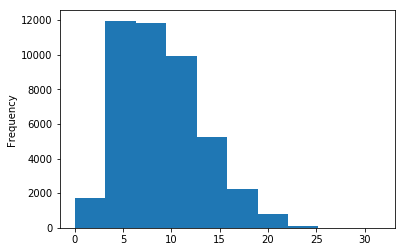

In [988]:
ax = np.sqrt(beijing['model_pm2.5']).plot.hist()

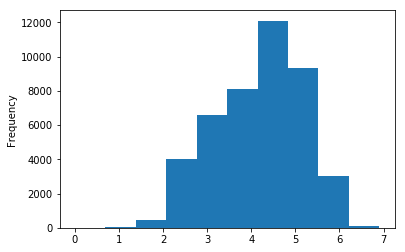

In [989]:
ax = np.log1p(beijing['model_pm2.5']).plot.hist()

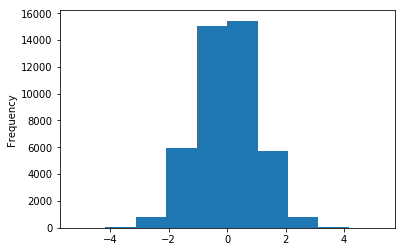

In [990]:
def fn(x):
    a = x.reshape([-1,1]).copy()
    # Expect flat numpy array
    y = quantile_transform(a, output_distribution='normal', random_state = 19)
    return y.flatten()
ax = pd.Series(fn(beijing['model_pm2.5'].values)).plot.hist()

In [991]:
beijing['pm'] = np.sqrt(beijing['model_pm2.5'])

#### Dew Point, Temperature, Pressure

In [992]:
vars = ['DEWP','TEMP','PRES']
beijing[vars] = beijing[vars].apply(lambda x: (x-x.mean())/x.std())

#### Wind Speed, Snowfall, Rainfall

In [993]:
vars = ['Iws','Is','Ir']
#beijing[vars] = beijing[vars].apply(np.sqrt)

# Use Indicator Variables for Zero or Low Level
beijing['No Snow'] = (beijing['Is'] < .001).astype('int')
beijing['No Rain'] = (beijing['Ir'] < .001).astype('int')
beijing['No Wind'] = (beijing['Iws'] < 1.0).astype('int')

In [994]:
cbwd = ['cbwd_NW', 'cbwd_NE', 'cbwd_SE', 'cbwd_cv']
beijing.groupby(cbwd + ['No Wind']).size().unstack()

No Wind                              0     1
cbwd_NW cbwd_NE cbwd_SE cbwd_cv             
0       0       0       1         4752  4635
                1       0        14558   732
        1       0       0         4009   988
1       0       0       0        13712   438

In [995]:
for col in cbwd:
    beijing.loc[beijing['No Wind']==1, col] = 0

In [996]:
beijing.describe()

,DEWP,TEMP,PRES,Iws,Is,Ir,model_pm2.5,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,pm,No Snow,No Rain,No Wind
count,4.382400e+04,4.382400e+04,4.382400e+04,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,-2.075335e-17,-5.188337e-18,4.871848e-15,23.889140,0.052734,0.194916,98.358182,0.091480,0.312888,0.332192,0.108434,8.957017,0.991603,0.958744,0.155006
std,1.000000e+00,1.000000e+00,1.000000e+00,50.010635,0.760375,1.415867,91.025248,0.288293,0.463674,0.471005,0.310931,4.257985,0.091252,0.198884,0.361915
min,-2.897247e+00,-2.578041e+00,-2.478177e+00,0.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.187408e-01,-8.565336e-01,-8.226607e-01,1.790000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,5.477226,1.000000,1.000000,0.000000
50%,1.266183e-02,1.271848e-01,-4.359406e-02,5.370000,0.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,8.544004,1.000000,1.000000,0.000000
75%,9.133480e-01,8.649737e-01,8.328559e-01,21.910000,0.000000,0.000000,136.591427,0.000000,1.000000,1.000000,0.000000,11.687233,1.000000,1.000000,0.000000
max,1.814034e+00,2.422528e+00,2.877906e+00,585.600000,27.000000,36.000000,994.000000,1.000000,1.000000,1.000000,1.000000,31.527766,1.000000,1.000000,1.000000


# 2. SARIMAX Model<a class="anchor" id="sarimax"></a>
#### Measurements at Midnight Only

In [997]:
midn_norm = beijing.drop('model_pm2.5', axis=1).iloc[::24,:].astype('float')

In [998]:
# Add Indicator Variable For Little Wind
midn_norm['No Rain'] = (midn_norm['Ir'] < .001).astype('int')

In [999]:
midn_norm.describe()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,pm,No Snow,No Rain,No Wind
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,0.053299,-0.193942,0.043870,25.077519,0.040526,0.209200,0.093100,0.277108,0.332968,0.082694,9.604959,0.991785,0.948521,0.214129
std,0.981782,0.944436,0.999225,53.427839,0.590798,1.380507,0.290652,0.447693,0.471404,0.275495,4.466003,0.090287,0.221032,0.410329
min,-2.550830,-2.414088,-2.186027,0.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.414214,0.000000,0.000000,0.000000
25%,-0.749457,-1.020487,-0.822661,1.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.324555,1.000000,1.000000,0.000000
50%,0.081945,-0.077756,0.053789,3.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.944272,1.000000,1.000000,0.000000
75%,0.982632,0.701021,0.832856,28.042500,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,12.449900,1.000000,1.000000,0.000000
max,1.744751,1.602762,2.877906,570.410000,19.000000,28.000000,1.000000,1.000000,1.000000,1.000000,27.276363,1.000000,1.000000,1.000000


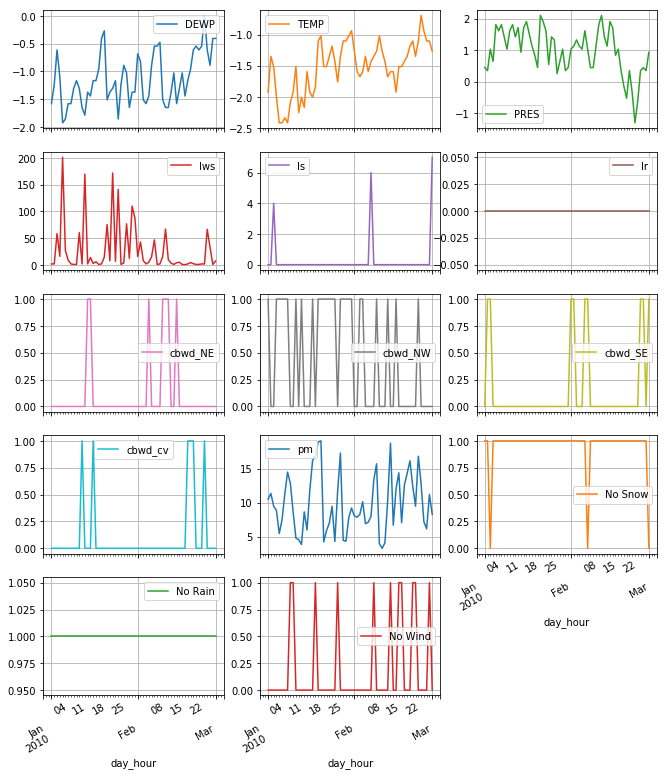

In [1000]:
ax = midn_norm.iloc[:60,:].plot(subplots=True,figsize=(11,14),grid=True,layout=(5,3))

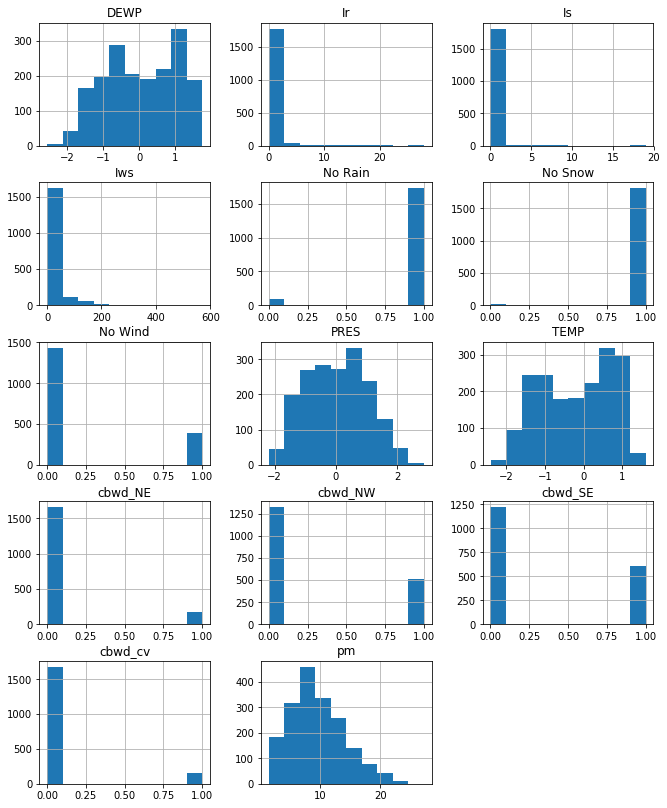

In [1001]:
ax = midn_norm.hist(figsize=(11,14),grid=True,layout=(5,3))

## 2.1 First-Pass Model<a class="anchor" id="sarimax_1"></a>

In [1002]:
from statsmodels.tsa.api import SARIMAX

exog_vars = ['DEWP', 'TEMP', 'PRES', 'No Rain', 'No Snow', 'Iws', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'cbwd_NE']


model = SARIMAX(endog=midn_norm.pm, exog = midn_norm[exog_vars], order = (1,1,1))

In [1003]:
results = model.fit(maxiter = 200)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                     pm   No. Observations:                 1826
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4676.950
Date:                Fri, 08 Feb 2019   AIC                           9379.901
Time:                        11:05:36   BIC                           9451.529
Sample:                    01-01-2010   HQIC                          9406.322
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DEWP           6.7106      0.242     27.758      0.000       6.237       7.184
TEMP          -1.6924      0.330     -5.125      0.000      -2.340      -1.045
PRES          -1.7058      0.182     -9.382      0.000      -2.062      -1.349
No Rain        1.8213      0.317      5.749      0.000       1.200       2.442
No Snow        1.4400      0.698      2.062      0.039       0.072       2.809
Iws           -0.0061      0.002     -3.450      0.001      -0.010      -0.003
cbwd_NW       -0.5453      0.212     -2.574      0.010      -0.961      -0.130
cbwd_SE       -0.1430      0.206     -0.693      0.489      -0.547       0.262
cbwd_cv        0.3752      0.269      1.394      0.163      -0.152       0.903
cbwd_NE       -0.8472      0.245     -3.454      0.001      -1.328      -0.366
ar.L1          0.2355      0.030      7.966      0.000       0.178       0.293
ma.L1         -0.8498      0.016    -53.541      0.000      -0.881      -0.819
sigma2         9.8480      0.314     31.396      0.000       9.233      10.463
===================================================================================
Ljung-Box (Q):                       70.44   Jarque-Bera (JB):                 8.38
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.05   Skew:                             0.13
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

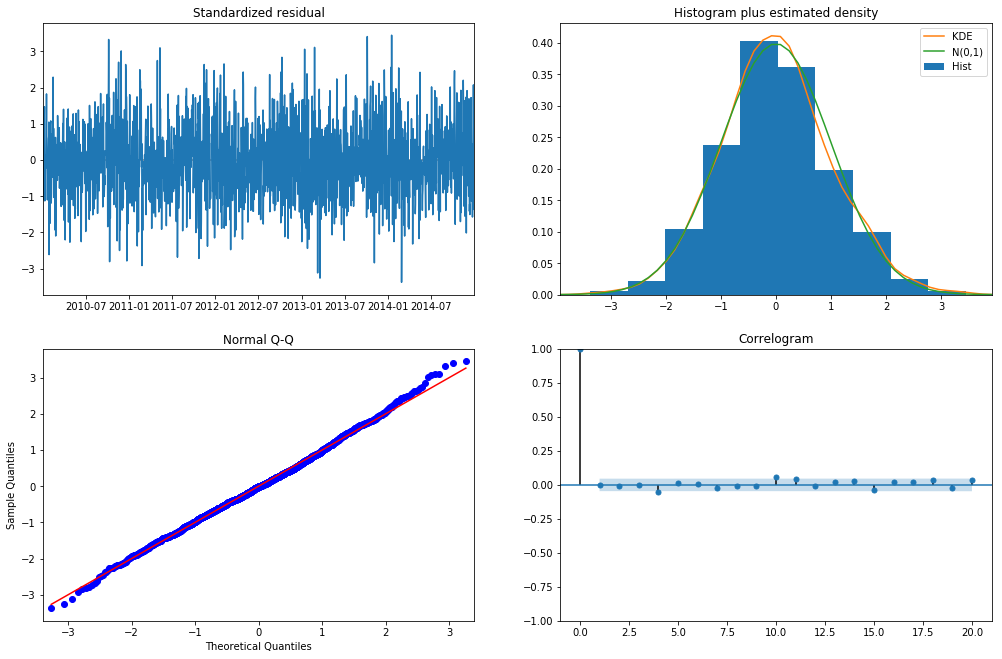

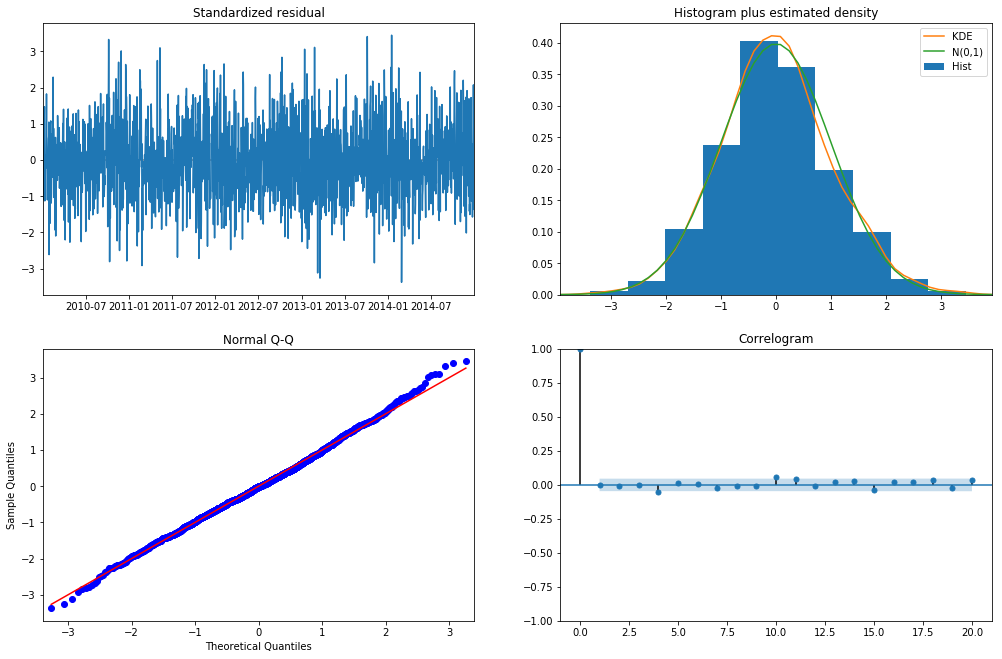

In [1004]:
results.plot_diagnostics(lags = 20, figsize = (17,11))

## 2.2 Final Model<a class="anchor" id="sarimax_2"></a>

In [1005]:
X = midn_norm.drop(["cbwd_cv"],axis=1)
exog_vars = [col for col in exog_vars if col in X.columns]
model = SARIMAX(X.pm, exog = X[exog_vars], order = (10,1,0))

In [1006]:
results = model.fit(maxiter=200, method = 'powell')
results.summary()

Optimization terminated successfully.
         Current function value: 2.558028
         Iterations: 3
         Function evaluations: 630


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                     pm   No. Observations:                 1826
Model:              SARIMAX(10, 1, 0)   Log Likelihood               -4670.959
Date:                Fri, 08 Feb 2019   AIC                           9381.917
Time:                        11:05:41   BIC                           9492.115
Sample:                    01-01-2010   HQIC                          9422.566
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DEWP           6.7640      0.246     27.527      0.000       6.282       7.246
TEMP          -1.3897      0.330     -4.215      0.000      -2.036      -0.744
PRES          -1.6617      0.184     -9.021      0.000      -2.023      -1.301
No Rain        1.7984      0.323      5.559      0.000       1.164       2.432
No Snow        1.5211      0.726      2.095      0.036       0.098       2.944
Iws           -0.0067      0.002     -3.878      0.000      -0.010      -0.003
cbwd_NW       -0.6816      0.196     -3.471      0.001      -1.066      -0.297
cbwd_SE       -0.3204      0.193     -1.657      0.098      -0.699       0.059
cbwd_NE       -0.9364      0.236     -3.968      0.000      -1.399      -0.474
ar.L1         -0.6108      0.022    -27.276      0.000      -0.655      -0.567
ar.L2         -0.5142      0.026    -19.897      0.000      -0.565      -0.464
ar.L3         -0.4315      0.028    -15.497      0.000      -0.486      -0.377
ar.L4         -0.4099      0.029    -14.241      0.000      -0.466      -0.353
ar.L5         -0.3117      0.031    -10.180      0.000      -0.372      -0.252
ar.L6         -0.2497      0.031     -8.032      0.000      -0.311      -0.189
ar.L7         -0.2303      0.030     -7.584      0.000      -0.290      -0.171
ar.L8         -0.1925      0.029     -6.579      0.000      -0.250      -0.135
ar.L9         -0.1549      0.027     -5.824      0.000      -0.207      -0.103
ar.L10        -0.0601      0.023     -2.587      0.010      -0.106      -0.015
sigma2         9.7834      0.314     31.189      0.000       9.169      10.398
===================================================================================
Ljung-Box (Q):                       49.04   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.15   Prob(JB):                         0.10
Heteroskedasticity (H):               1.04   Skew:                             0.08
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

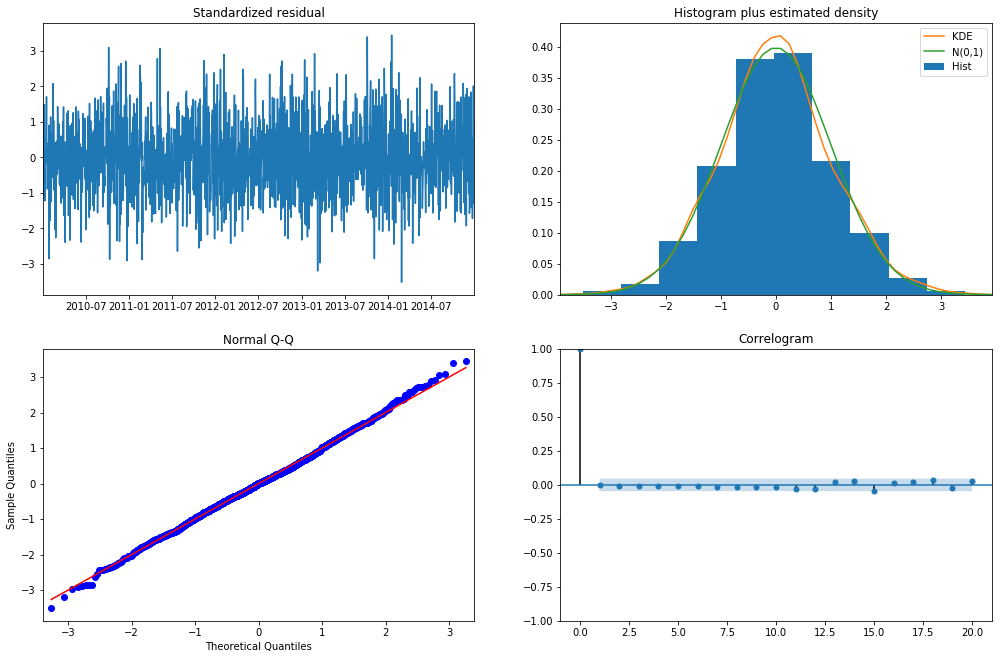

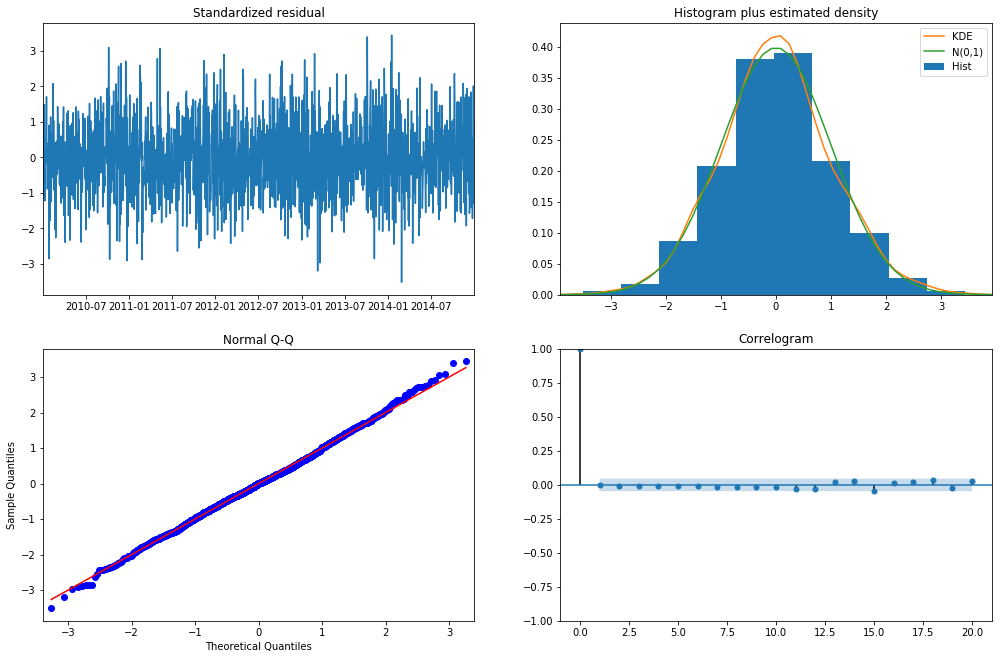

In [1007]:
results.plot_diagnostics(lags = 20, figsize = (17,11))

### SPECIFICATION TESTS
* Residual Autocorrelation : PASS
* Heteroschedasticity: PASS
* Normality: PASS

# 3. RESULTS<a class="anchor" id="results"></a>

#### POSITIVE EFFECTS ON RATE OF GROWTH
* Dew Point
* No Rain
* No Snow

#### NEGATIVE EFFECTS ON RATE OF GROWTH
* Temperature
* Atmospheric Pressure
* Winds from NW or NE (Speed > 1.0)